In [1]:
import meshplot as mp
from datasets import BRepDataModule
from automate import PartFeatures
import meshplot as mp
import numpy as np

In [28]:
import torch_geometric as tg
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
import random
import torch
import json
from tqdm import tqdm

def create_subset(data, seed, size):
    random.seed(seed)
    return random.sample(data, size)

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = tg.nn.GCNConv(in_channels, 2*out_channels)
        self.conv2 = tg.nn.GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class CodeGraphAutoencoder(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = tg.nn.GAE(GCNEncoder(64,16))
    def forward(self, batch):
        return self.model.encode(batch.x, batch.edge_index)
    def training_step(self, batch, batch_idx):
        z = self(batch)
        loss = self.model.recon_loss(z, batch.edge_index)
        self.log('train_loss',loss, on_step=True,on_epoch=True,batch_size=z.shape[0])
        return loss
    def validation_step(self, batch, batch_idx):
        z = self(batch)
        loss = self.model.recon_loss(z, batch.edge_index)
        self.log('val_loss',loss,on_step=True,on_epoch=True,batch_size=z.shape[0])
    def test_step(self, batch, batch_idx):
        z = self(batch)
        loss = self.model.recon_loss(z, batch.edge_index)
        self.log('test_loss',loss,on_step=False,on_epoch=True,batch_size=z.shape[0])
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

from automate import LinearBlock, BipartiteResMRConv
from torch.nn import ModuleList
from torchmetrics import Accuracy
from torch.nn.functional import cross_entropy
class CodePredictor(pl.LightningModule):
    def __init__(self, in_channels, out_channels, mlp_layers, mp_layers):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mlp_layers = mlp_layers
        self.mp_layers = mp_layers
        
        self.mp = ModuleList([BipartiteResMRConv(in_channels) for _ in range(mp_layers)])
        self.mlp = LinearBlock(*([in_channels]*mlp_layers), out_channels, last_linear=True)
        
        self.train_acc = Accuracy()
        self.val_acc = Accuracy()
        self.test_acc = Accuracy()
        
    def forward(self, data):
        x = data.x#torch.cat([data.x,data.z],dim=1)
        for mp in self.mp:
            x = mp(x,x,data.edge_index)
        x = self.mlp(x)
        return x
    
    def training_step(self, batch, batch_idx):
        scores = self(batch)
        preds = scores.argmax(dim=1)
        target = batch.y.reshape(-1)
        loss = cross_entropy(scores, target)
        self.train_acc(preds, target)
        batch_size = len(target)
        self.log('train_loss',loss,on_epoch=True,on_step=True,batch_size=batch_size)
        self.log('train_acc',self.train_acc,on_epoch=True,on_step=True,batch_size=batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        scores = self(batch)
        preds = scores.argmax(dim=1)
        target = batch.y.reshape(-1)
        loss = cross_entropy(scores, target)
        self.val_acc(preds, target)
        batch_size = len(target)
        self.log('val_loss',loss,on_epoch=True,on_step=True,batch_size=batch_size)
        self.log('val_acc',self.val_acc,on_epoch=True,on_step=True,batch_size=batch_size)
    
    def test_step(self, batch, batch_idx):
        scores = self(batch)
        preds = scores.argmax(dim=1)
        target = batch.y.reshape(-1)
        loss = cross_entropy(scores, target)
        self.test_acc(preds, target)
        batch_size = len(target)
        self.log('test_loss',loss,on_epoch=True,on_step=False,batch_size=batch_size)
        self.log('test_acc',self.test_acc,on_epoch=True,on_step=False,batch_size=batch_size)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        

class DictDataset(torch.utils.data.Dataset):
    def __init__(self, index, data, mode='train', val_frac=.2,seed=42,undirected=True,train_size=None):
        index
        keyset = index['test']
        if mode in ['train', 'validate']:
            keyset = index['train']
            if train_size:
                keyset = create_subset(keyset, seed, train_size)
            train_keys, val_keys = train_test_split(keyset, test_size=val_frac, random_state=seed)
            keyset = train_keys if mode == 'train' else val_keys
        self.data = {i:tg.data.Data(**data[index['template'].format(*key)]) for i,key in enumerate(keyset)}
        if undirected:
            for k,v in self.data.items():
                v.edge_index = torch.cat([v.edge_index, v.edge_index[[1,0]]],dim=1)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class DictDatamodule(pl.LightningDataModule):
    def __init__(self, index, data, val_frac=0.2, seed=42, batch_size=32,train_size=None):
        super().__init__()
        self.val_frac = val_frac
        self.seed = seed
        self.ds_train = DictDataset(index, data, 'train', val_frac, seed, True, train_size)
        self.ds_val = DictDataset(index, data, 'validate', val_frac, seed, True, train_size)
        self.ds_test = DictDataset(index, data, 'test')
        self.batch_size = batch_size
    
    def train_dataloader(self):
        return DataLoader(
            self.ds_train, 
            batch_size=min(len(self.ds_train), self.batch_size), 
            shuffle=True, 
            num_workers=8, 
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.ds_val, 
            batch_size=min(len(self.ds_val),self.batch_size), 
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=1, shuffle=False)

In [3]:
with open('/projects/grail/benjonesnb/cadlab/siggasia2022/fusion360seg.json','r') as f:
    index = json.load(f)
    coded_set = torch.load('/projects/grail/benjonesnb/cadlab/siggasia2022/precoded/fusion360seg_coded.pt')

In [4]:
datamodule = DictDatamodule(
                    index, 
                    coded_set, 
                    train_size=23266, 
                    seed=0, 
                    batch_size=512
                )

In [29]:
model = CodePredictor(64, 16, 2, 2)

In [11]:
import os

In [12]:
ckpt_path = '/projects/grail/benjonesnb/cadlab/siggasia2022/tensorboard/f360seg/mp2_23266_0/version_0/checkpoints/epoch=201-val_loss=0.232968.ckpt'

In [114]:
int('mp2'[-1])

2

In [116]:

def load_model(mp_layers, tb_dir):
    checkpoint_dir = os.path.join(tb_dir, 'version_0', 'checkpoints')
    checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt') and 'val_loss' in f]
    model = CodePredictor(64, 16, 2, mp_layers)
    sd = torch.load(checkpoints[0],map_location='cpu')['state_dict']
    model.load_state_dict(sd)
    return model

def load_models(root='/projects/grail/benjonesnb/cadlab/siggasia2022/tensorboard/f360seg/', seed = 0):
    model_dirs = [(d.split('_')[0], int(d.split('_')[1]), os.path.join(root,d)) for d in os.listdir(root) if '_' in d and os.path.isdir(os.path.join(root,d)) and int(d.split('_')[-1]) == seed]
    m_dir_dict = dict()
    for model, train_size, path in model_dirs:
        ms = m_dir_dict.get(model, [])
        ms.append((train_size, path))
        m_dir_dict[model] = ms
    for k,v in m_dir_dict.items():
        m_dir_dict[k] = sorted(v, key=lambda x: x[0])
    for k,v in m_dir_dict.items():
        for i,(s, p) in enumerate(v):
            v[i] = (s, load_model(int(k[-1]), p))
    return m_dir_dict
all_models = load_models()
our_models = all_models['mp2']

In [123]:
[m[0] for m in our_models]

[10, 100, 1000, 10000, 20000, 23266]

In [125]:
test_ds[0].y

tensor([6, 6, 6, 6, 6, 6, 6])

In [ ]:
# for each part in the train set, compute its face accuracy at each model size

In [126]:
accs = np.zeros((len(test_ds), len(our_models)))
for i in tqdm(range(len(test_ds))):
    data = test_ds[i]
    for j, (ts, m) in enumerate(our_models):
        with torch.no_grad():
            preds = m(data).argmax(dim=1).numpy()
        targets = data.y.numpy()
        acc = (preds.flatten() == targets.flatten()).sum() / len(targets.flatten())
        accs[i,j] = acc

100%|██████████████████████████████████████████████████████████████| 4184/4184 [00:27<00:00, 154.45it/s]


In [132]:
from matplotlib import pyplot as plt

In [142]:
local_auc = accs.sum(axis = 1) - accs[:,0] / 2 - accs[:,-1] / 2

In [153]:
complexity = np.array([len(test_ds[i].y) for i in range(len(test_ds))])

In [156]:
sorted_by_auc = sorted(enumerate(zip(local_auc, complexity)), key=lambda x:x[1][0])

In [176]:
filtered_examples = [x for x in sorted_by_auc if x[1][1] > 30]

In [162]:
max([i for j in index['test_labels'] for i in j])

7

In [172]:
color_pallet = np.array([
    [51, 92, 103],
    [255, 243, 176],
    [224, 159, 62],
    [158, 42, 43],
    [84, 11, 14],
    [0, 0, 0],
    [255, 255, 255],
    [128, 128, 128]
]) / 255

In [ ]:
# Good examples: 
# 779, 3229, 2112, 345, 1709, 1067, 634, 2093, 2282, 535, 2947, 3494, 1979, 2995, 2616, 2052
# 27, 1290, 909

In [276]:
def plot_part(V, F, E2T, FC=None):
    plot = mp.plot(V, F, c = FC)
    E = np.concatenate([
        F[E2T[:,0]>=0][:,[2,0]], 
        F[E2T[:,1]>=0][:,[0,1]],
        F[E2T[:,2]>=0][:,[1,2]]
    ], axis=0)
    plot.add_edges(V, E, shading={'line_width':0.5})
def plot_preds(i, test_ds, test_keys, zf, models, colormap, just_gt=False):
    data = test_ds[i]
    with zf.open(test_keys[i],'r') as f:
        p = Part(f.read().decode('utf-8'))
    target = data.y.numpy()
    target_c = colormap[target[p.mesh_topology.face_to_topology]]
    plot_part(p.mesh.V, p.mesh.F, p.mesh_topology.edge_to_topology,  target_c)
    if just_gt:
        return
    model_preds = []
    for ts, model in models:
        with torch.no_grad():
            preds = model(data).argmax(dim=1).numpy()
            model_preds.append(preds)   
    for preds in model_preds:
        pred_c = colormap[preds[p.mesh_topology.face_to_topology]]
        plot_part(p.mesh.V, p.mesh.F, p.mesh_topology.edge_to_topology, pred_c)


In [237]:
i = 779
with zf.open(test_keys[i],'r') as f:
        p = Part(f.read().decode('utf-8'))

In [246]:
V = p.mesh.V
F = p.mesh.F
E2T = p.mesh_topology.edge_to_topology


In [ ]:
# Good examples: 
# 779, 3229, 2112, 345, 1709, 1067, 634, 2093, 2282, 535, 2947, 3494, 1979, 2995, 2616, 2052
# 27, 1290, 909

In [274]:
gallery_examples = [779, 1709, 1067, 634, 1979, 2052, 909]

In [285]:
for row in accs[gallery_examples]:
    print('new row')
    for col in row:
        print(f'{col*100:.1f}%')
                

new row
9.7%
6.5%
41.9%
54.8%
58.1%
58.1%
new row
15.4%
14.1%
24.4%
71.8%
93.6%
89.7%
new row
36.4%
30.3%
45.5%
72.7%
75.8%
93.9%
new row
14.7%
50.0%
70.6%
79.4%
85.3%
85.3%
new row
43.9%
61.0%
65.9%
87.8%
92.7%
95.1%
new row
19.7%
76.3%
86.9%
99.0%
100.0%
99.5%
new row
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%


In [277]:
for i in gallery_examples:
    plot_preds(i, test_ds, test_keys, zf, our_models, color_pallet, just_gt=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004967…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [181]:
len(filtered_examples)

270

In [232]:
k = -50
print(filtered_examples[k])
plot_preds(filtered_examples[k][0], color_pallet)

(27, (4.663265306122449, 49))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000671…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000671…

In [ ]:
plot_preds()

In [13]:
sd = torch.load(ckpt_path,map_location='cpu')['state_dict']

In [30]:
model.load_state_dict(sd)

<All keys matched successfully>

In [15]:
test_ds = datamodule.ds_test

Data(x=[7, 64], edge_index=[2, 30], y=[7], z=[7, 16], xz=[7, 80])

In [18]:
from zipfile import ZipFile

In [19]:
zf = ZipFile('/projects/grail/benjonesnb/cadlab/siggasia2022/fusion360seg.zip')

In [22]:
test_keys = [index['template'].format(*x) for x in index['test']]

In [23]:
from pspy import Part

In [170]:
def plot_preds(i, colormap):
    data = test_ds[i]
    with zf.open(test_keys[i],'r') as f:
        p = Part(f.read().decode('utf-8'))
    with torch.no_grad():
        preds = model(data).argmax(dim=1).numpy()
    target = data.y.numpy()
    pred_c = colormap[preds[p.mesh_topology.face_to_topology]]
    target_c = colormap[target[p.mesh_topology.face_to_topology]]
    mp.plot(p.mesh.V, p.mesh.F, c=pred_c)
    mp.plot(p.mesh.V, p.mesh.F, c=target_c)

In [75]:
import random

359

In [92]:
i = random.randint(0, len(test_ds))
plot_preds(i)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0012383…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0012383…

In [62]:
target

array([6, 6, 6, 6, 6, 6, 6])

In [61]:
preds

array([6, 6, 4, 6, 4, 6, 6])

In [60]:
mp.plot(p.mesh.V, p.mesh.F, c=pred_c)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010567…

In [37]:
preds.numpy()

array([6, 6, 4, 6, 4, 6, 6])

In [287]:
accs.shape

(4184, 6)

In [294]:
import seaborn as sns

In [295]:
accs

array([[0.        , 0.57142857, 0.71428571, 0.71428571, 0.85714286,
        0.71428571],
       [0.22222222, 0.55555556, 0.77777778, 1.        , 1.        ,
        1.        ],
       [0.6       , 0.8       , 0.6       , 0.6       , 0.6       ,
        0.8       ],
       ...,
       [0.5       , 0.66666667, 0.83333333, 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.25      , 0.6875    , 0.9375    , 0.9375    , 0.9375    ,
        1.        ]])

In [296]:
with open('/projects/grail/benjonesnb/cadlab/siggasia2022/baselines/Fusion360Seg_UV-Net.json','r') as f:
    uvnet360 = json.load(f)

In [307]:
sum([len(x) for x in uvnet360['labels']])

52926

In [360]:
labels = uvnet360['labels']
logits = uvnet360['logits']['100'][0]
uv_preds = [np.array(l).argmax() for l in logits]
part_accs_uv = []
offset = 0
part_preds_uv = []
for part_labels in labels:
    part_preds = uv_preds[offset:offset+len(part_labels)]
    part_preds_uv.append(part_preds)
    part_accs_uv.append((np.array(part_preds) == np.array(part_labels)).sum() / len(part_labels))
    offset += len(part_labels)
part_accs_uv = np.array(part_accs_uv)

In [321]:
with open('/projects/grail/benjonesnb/cadlab/siggasia2022/baselines/Fusion360Seg_BRepNet.json','r') as f:
    brep360 = json.load(f)

In [361]:
labels = brep360['labels']
logits = brep360['logits']['100'][0]
preds = [np.array(l).argmax() for ll in logits for l in ll]
part_accs_brep = []
part_preds_brep = []
offset = 0
for i, part_labels in enumerate(labels):
    part_preds = preds[offset:offset+len(part_labels)]
    part_preds_brep.append(part_preds)
    part_accs_brep.append((np.array(part_preds) == np.array(part_labels)).sum() / len(part_labels))
    offset += len(part_labels)
part_accs_brep = np.array(part_accs_brep)

In [362]:
part_accs_ours = accs[:,1]

In [363]:
lift = (part_accs_ours - part_accs_brep) + (part_accs_ours - part_accs_uv)

In [410]:
nuanced_wins = [x for x in sorted(enumerate(zip(lift,complexity, part_accs_ours, part_accs_uv, part_accs_brep)), reverse=True, key = lambda x : x[1]) 
 if x[1][1] > 25 and x[1][3] > .1 and x[1][4] > .1]

In [368]:
part_preds_uv[2031].__len__()

26

In [525]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import pyrender
from zipfile import ZipFile
import json
import numpy as np
import torch
from pspy import Part
import meshplot as mp
import trimesh
from matplotlib import pyplot as plt
import scipy
def look_at(point, pos, up):
    z = pos - point
    x = np.cross(up, z)
    y = np.cross(z, x)
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    z = z / np.linalg.norm(z)
    pose = np.eye(4)
    pose[:3,0] = x
    pose[:3,1] = y
    pose[:3,2] = z
    pose[:3,3] = pos
    return pose
def find_best_angle(part, cubify=True, normalize=True):
    V = part.mesh.V
    if normalize: # assuming centered part for now
        max_coord = np.abs(V).max()
        scale = 1 / max_coord
        V = V * scale
    bb = np.stack([V.min(axis = 0), V.max(axis=0)])
    #bb = part.summary.bounding_box
    face_labels = np.tile(part.mesh_topology.face_to_topology, (3,1)).T.astype(int)
    mesh = trimesh.Trimesh(vertices=V, faces=part.mesh.F, face_colors=face_labels)
    pmesh = pyrender.Mesh.from_trimesh(mesh, smooth=False)
    r = pyrender.OffscreenRenderer(viewport_width=800, viewport_height=800, point_size=1.0)
    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
    
    c = bb.sum(axis=0) # bounding box center
    
    if cubify:
        s = np.abs(bb - c).max()
        bb = np.array([
            [c[0]-s,c[1]-s,c[2]-s],
            [c[0]+s,c[1]+s,c[2]+s]
        ])
        
        
    side_positions = [
        [c[0],c[1],bb[0,2]*1.1], # front
        [c[0],c[1],bb[1,2]*1.1], # back
        [bb[0,0]*1.1,c[1],c[2]], # left
        [bb[1,0]*1.1,c[1],c[2]], # right
    ]    
    
    top_corner_positions = [
        [bb[0,0],bb[1,1],bb[0,2]], # front top left
        [bb[1,0],bb[1,1],bb[0,2]], # front top right
        [bb[0,0],bb[1,1],bb[1,2]], # back top left
        [bb[1,0],bb[1,1],bb[1,2]], # back top right
    ]
    
    bottom_corner_positions = [
        [bb[0,0],bb[0,1],bb[0,2]], # front bottom left
        [bb[1,0],bb[0,1],bb[0,2]], # front bottom right   
        [bb[0,0],bb[0,1],bb[1,2]], # back bottom left
        [bb[1,0],bb[0,1],bb[1,2]], # back bottom right
    ]
    
    side_top_position = [
        [c[0],bb[1,1],bb[0,2]*1.1], # front top
        [c[0],bb[1,1],bb[1,2]*1.1], # back top
        [bb[0,0]*1.1,bb[1,1],c[2]], # left top
        [bb[1,0]*1.1,bb[1,1],c[2]], # right top
    ]
    
    side_bottom_position = [
        [c[0],bb[0,1],bb[0,2]*1.1], # front bottom
        [c[0],bb[0,1],bb[1,2]*1.1], # back bottom
        [bb[0,0]*1.1,bb[0,1],c[2]], # left bottom
        [bb[1,0]*1.1,bb[0,1],c[2]], # right bottom
    ]
    
    candidate_positions = top_corner_positions

    if cubify:
        s = np.abs(bb - c).max()
        bb = np.array([
            [c[0]-s,c[1]-s,c[2]-s],
            [c[0]+s,c[1]+s,c[2]+s]
        ])
    
        top_corner_positions = [
            [bb[0,0],bb[1,1],bb[0,2]], # front top left
            [bb[1,0],bb[1,1],bb[0,2]], # front top right
            [bb[0,0],bb[1,1],bb[1,2]], # back top left
            [bb[1,0],bb[1,1],bb[1,2]], # back top right
        ]
        
        candidate_positions += top_corner_positions
    
        
    n_visible_faces = []
    image_areas = []
    candidate_poses = []
    zooms = []
    depths = []
    #candidate_renderings = []
    for pos in candidate_positions:
        camera_pose = look_at(c, pos, [0,1,0])
        candidate_poses.append(camera_pose)
        zoom = 1.2 * np.abs(camera_pose[:3,:3].dot(bb.T)).max()
        zooms.append(zoom)
        cam = pyrender.OrthographicCamera(xmag=zoom, ymag=zoom)
        scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
        scene.add(pmesh, pose=np.eye(4))
        scene.add(cam, pose=camera_pose)
        color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT | pyrender.constants.RenderFlags.SKIP_CULL_FACES)
        n_visible_faces.append(len(np.unique(color[:,:,0].flatten()[color[:,:,0].flatten() <= face_labels[:,0].max()])))
        image_areas.append((depth > 0).sum())
        depths.append(depth)
        #candidate_renderings.append(color)
    ordering = sorted(enumerate(zip(n_visible_faces, image_areas)), key=lambda x: x[1], reverse=True)
    best_idx = ordering[0][0]
    best_zoom = zooms[best_idx]
    # Rescale to maximize image in frame
    depth = depths[best_idx]
    mask = depth > 0
    mg = np.stack(np.meshgrid(np.linspace(-1,1,800),np.linspace(-1,1,800)),axis=-1)
    zoom_factor = np.abs(mg.reshape((-1,2))[mask.flatten()]).max() * 1.05 # add 5% for some margin
    return candidate_poses[best_idx], zoom_factor * best_zoom
def render_part(
        part, camera_pose, zoom, 
        max_labels = None, face_labels=None, cmap='tab20', 
        renderer = None,viewport_width=800, viewport_height=800, point_size=1.0,
        normalize=True
):
    V = part.mesh.V
    if normalize: # assuming centered part for now
        max_coord = np.abs(V).max()
        scale = 1 / max_coord
        V = V * scale
    
    inferred_max_labels = (part.mesh_topology.face_to_topology.max() + 1)
    if max_labels and face_labels is None:
        inferred_max_labels = max_labels
    if not max_labels:
        max_labels = inferred_max_labels

    if isinstance(cmap, str):
        palette = plt.cm.get_cmap(cmap, lut=inferred_max_labels)
    else:
        palette = plt.cm.get_cmap('tab20', lut=inferred_max_labels)
    
    tri_labels = part.mesh_topology.face_to_topology
    
    face_colors = (palette(tri_labels)*255).astype(int)
    
    mesh = trimesh.Trimesh(vertices=V, faces=part.mesh.F, face_colors=face_colors)
    pmesh = pyrender.Mesh.from_trimesh(mesh, smooth=False)
    
    cam = pyrender.OrthographicCamera(xmag=zoom, ymag=zoom)
    
    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
    scene.add(pmesh, pose=np.eye(4))
    scene.add(cam, pose=camera_pose)
    
    if not renderer:
        r = pyrender.OffscreenRenderer(viewport_width=viewport_width, viewport_height=viewport_height, point_size=point_size)
    
    # Rendering an image with independent face colors. Do this first regardless of overridding
    # color labels in order to compute hard edges for edge rendering
    color, _ = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT | pyrender.constants.RenderFlags.SKIP_CULL_FACES)
    
    # Detect Edges to add to image
    laplace_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    edge_mask = (
        (scipy.ndimage.convolve(color[:,:,0], laplace_kernel) 
         + scipy.ndimage.convolve(color[:,:,1], laplace_kernel) 
         + scipy.ndimage.convolve(color[:,:,2], laplace_kernel)) == 0
    ).astype(int)
    
    # If we have custom face coloring labels, re-render the colors
    if face_labels is not None or not isinstance(cmap, str):
        if isinstance(cmap, str):
            palette = plt.cm.get_cmap(cmap, lut=max_labels)
        else:
            palette = cmap
        tri_labels = face_labels[tri_labels]
        face_colors = (np.array(palette(tri_labels))*255).astype(int)
        mesh = trimesh.Trimesh(vertices=V, faces=part.mesh.F, face_colors=face_colors)
        pmesh = pyrender.Mesh.from_trimesh(mesh, smooth=False)
        scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
        scene.add(pmesh, pose=np.eye(4))
        scene.add(cam, pose=camera_pose)
        color, _ = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT | pyrender.constants.RenderFlags.SKIP_CULL_FACES)

    
    color_with_edges = np.stack([edge_mask]*3,axis=-1)*color
    
    if not renderer:
        r.delete()
    
    return color_with_edges
def render_mesh(
        V, F, labels, camera_pose, zoom, 
        max_labels = None, face_ids = None, face_labels=None, cmap='tab20', 
        renderer = None,viewport_width=800, viewport_height=800, point_size=1.0
):
    
    inferred_max_labels = (labels.max() + 1)
    if max_labels and face_labels is None:
        inferred_max_labels = max_labels
    if not max_labels:
        max_labels = inferred_max_labels
    
    if isinstance(cmap, str):
        palette = plt.cm.get_cmap(cmap, lut=inferred_max_labels)
    else:
        palette = plt.cm.get_cmap('tab20', lut=inferred_max_labels)
    
    tri_labels = labels
    
    face_colors = (palette(tri_labels)*255).astype(int)
    
    mesh = trimesh.Trimesh(vertices=V, faces=F, face_colors=face_colors)
    pmesh = pyrender.Mesh.from_trimesh(mesh, smooth=False)
    
    cam = pyrender.OrthographicCamera(xmag=zoom, ymag=zoom)
    
    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
    scene.add(pmesh, pose=np.eye(4))
    scene.add(cam, pose=camera_pose)
    
    if not renderer:
        r = pyrender.OffscreenRenderer(viewport_width=viewport_width, viewport_height=viewport_height, point_size=point_size)
    
    # Rendering an image with independent face colors. Do this first regardless of overridding
    # color labels in order to compute hard edges for edge rendering
    color, _ = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT | pyrender.constants.RenderFlags.SKIP_CULL_FACES)
    
    # Detect Edges to add to image
    laplace_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    edge_mask = (
        (scipy.ndimage.convolve(color[:,:,0], laplace_kernel) 
         + scipy.ndimage.convolve(color[:,:,1], laplace_kernel) 
         + scipy.ndimage.convolve(color[:,:,2], laplace_kernel)) == 0
    ).astype(int)
    
    # If we have custom face coloring labels, re-render the colors
    if face_labels is not None or not isinstance(cmap, str):
        if isinstance(cmap, str):
            palette = plt.cm.get_cmap(cmap, lut=max_labels)
        else:
            palette = cmap
        tri_labels = face_labels[tri_labels]
        face_colors = (np.array(palette(tri_labels))*255).astype(int)
        mesh = trimesh.Trimesh(vertices=V, faces=F, face_colors=face_colors)
        pmesh = pyrender.Mesh.from_trimesh(mesh, smooth=False)
        scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])
        scene.add(pmesh, pose=np.eye(4))
        scene.add(cam, pose=camera_pose)
        color, _ = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT | pyrender.constants.RenderFlags.SKIP_CULL_FACES)

    
    color_with_edges = np.stack([edge_mask]*3,axis=-1)*color
    
    if not renderer:
        r.delete()
    
    return color_with_edges

In [509]:
with open('/projects/grail/benjonesnb/cadlab/siggasia2022/fusion360seg.json','r') as f:
    index = json.load(f)
data =  ZipFile('/projects/grail/benjonesnb/cadlab/siggasia2022/fusion360seg.zip','r')
parts_list = [index['template'].format(*x) for x in index['test']]

In [398]:
model = our_models[1][1]

In [405]:
i = 665
part = Part(data.open(parts_list[665]).read().decode('utf-8'))
pose, zoom = find_best_angle(part, cubify=True)

gt = np.array(labels[i])
pdata = test_ds[i]
our_preds = model(pdata).argmax(dim=1).numpy().astype(int)
uv_preds = np.array(part_preds_uv[i]).astype(int)
brep_preds = np.array(part_preds_brep[i]).astype(int)

gt_im = render_part(part, pose, zoom, face_labels=gt, max_labels=8)
our_im = render_part(part, pose, zoom, face_labels=our_preds, max_labels=8)
uv_im = render_part(part, pose, zoom, face_labels=uv_preds, max_labels=8)
brep_im = render_part(part, pose, zoom, face_labels=brep_preds, max_labels=8)


In [411]:
s=5
M = 10
#selection = [x for x in sorted(enumerate(zip(lift,complexity)), reverse=True, key = lambda x : x[1]) if x[1][1] > 25][:M]
selection = nuanced_wins[:M]
fig, axes = plt.subplots(M,4, figsize=(4*s,M*s),gridspec_kw={'wspace':0,'hspace':0},dpi=300)
for k, sel in enumerate(tqdm(selection)):
    i = sel[0]
    part = Part(data.open(parts_list[i]).read().decode('utf-8'))
    pose, zoom = find_best_angle(part, cubify=True)

    gt = np.array(labels[i])
    pdata = test_ds[i]
    our_preds = model(pdata).argmax(dim=1).numpy().astype(int)
    uv_preds = np.array(part_preds_uv[i]).astype(int)
    brep_preds = np.array(part_preds_brep[i]).astype(int)

    gt_im = render_part(part, pose, zoom, face_labels=gt, max_labels=8)
    our_im = render_part(part, pose, zoom, face_labels=our_preds, max_labels=8)
    uv_im = render_part(part, pose, zoom, face_labels=uv_preds, max_labels=8)
    brep_im = render_part(part, pose, zoom, face_labels=brep_preds, max_labels=8)
    axes[k,0].imshow(gt_im)
    axes[k,1].imshow(our_im)
    axes[k,2].imshow(uv_im)
    axes[k,3].imshow(brep_im)
    for ax in axes[k]:
        ax.axis('off')


100%|███████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.36s/it]


In [412]:
fig.savefig('comparisons.png')

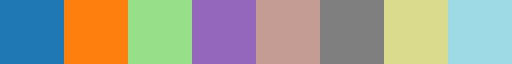

In [414]:
plt.cm.get_cmap('tab20', lut=8)

In [418]:
names = set(data.namelist())

In [421]:
with data.open('s2.0.0/segment_names.json', 'r') as f:
    seg_names = json.load(f)

In [422]:
seg_names

['ExtrudeSide',
 'ExtrudeEnd',
 'CutSide',
 'CutEnd',
 'Fillet',
 'Chamfer',
 'RevolveSide',
 'RevolveEnd']

In [425]:
np.bincount(np.array([l for ll in labels for l in ll]))

array([27911,  9648,  6301,  1402,  3473,  1587,  2573,    31])

In [426]:
accs

array([[0.        , 0.57142857, 0.71428571, 0.71428571, 0.85714286,
        0.71428571],
       [0.22222222, 0.55555556, 0.77777778, 1.        , 1.        ,
        1.        ],
       [0.6       , 0.8       , 0.6       , 0.6       , 0.6       ,
        0.8       ],
       ...,
       [0.5       , 0.66666667, 0.83333333, 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.25      , 0.6875    , 0.9375    , 0.9375    , 0.9375    ,
        1.        ]])

In [427]:
testing_losses = torch.load('f360_render_test_losses.pt')

In [433]:
total_losses = torch.stack([x[0]*x[1] for x in testing_losses]).numpy()
avg_losses = torch.stack([x[0]*x[1] for x in testing_losses]).numpy()

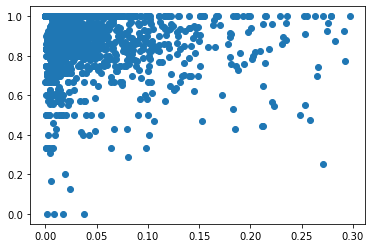

In [455]:
plt.scatter(avg_losses[avg_losses < .3], accs[:,5][avg_losses < .3])

In [456]:
face_render_losses = torch.load('f360_render_test_face_losses.pt')

In [460]:
accs.shape

(4184, 6)

In [463]:
records = []

for i in tqdm(range(len(test_ds))):
    render_losses = face_render_losses[i]
    data = test_ds[i]
    for j, (ts, m) in enumerate(our_models):
        with torch.no_grad():
            preds = m(data).argmax(dim=1).numpy()
        targets = data.y.numpy()
        correct = (preds.flatten() == targets.flatten()).astype(int)
        for k,c in enumerate(correct):
            records.append({
                'train_size':ts,
                'mse':render_losses[k].item(),
                'label':correct[k].item(),
                'test_idx':i,
                'face_idx':k
            })

100%|██████████████████████████████████████████████████████████████| 4184/4184 [00:29<00:00, 140.13it/s]


In [466]:
import pandas as pd

In [467]:
import altair as alt

In [468]:
df_face_acc = pd.DataFrame.from_records(records)

In [477]:
alt.Chart(df_face_acc[df_face_acc.train_size == 10000]).mark_bar().encode(
    x=alt.X('mse',bin=True),
    y='sum(label)'
)

alt.Chart(...)

In [ ]:
alt.data_transformers.disable_max_rows()


In [478]:
df_face_acc.to_parquet('df_face_acc.parquet')

In [490]:
# Let's find a part with bad faces and bad, but not awful, accuracy
sorted_accs = df_face_acc[df_face_acc.train_size==23266].groupby('test_idx').agg('mean').sort_values('mse', ascending=False)

In [491]:
# Let's find a part with bad faces and bad, but not awful, accuracy
sorted_accs = df_face_acc[df_face_acc.train_size==23266].groupby('test_idx').agg('mean').sort_values('mse', ascending=False)
sorted_accs

,train_size,mse,label,face_idx
test_idx,,,,
2670,23266.0,1.549387,0.785714,6.5
1481,23266.0,0.407262,0.500000,1.5
3553,23266.0,0.135760,0.833333,2.5
2945,23266.0,0.118064,0.900000,4.5
291,23266.0,0.115256,0.833333,2.5
...,...,...,...,...
2736,23266.0,0.000075,1.000000,2.5
2316,23266.0,0.000074,1.000000,2.5
1457,23266.0,0.000072,1.000000,1.0


In [492]:
1481

1481

In [511]:
from train_latent_space import BRepDS, BRepFaceAutoencoder, BRepFaceEncoder

render_model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load('/projects/grail/benjonesnb/cadlab/siggasia2022/precoded/BRepFaceAutoencoder_64_1024_4.ckpt')
model.load_state_dict(ckpt['state_dict'])

codes = torch.load('/projects/grail/benjonesnb/cadlab/siggasia2022/precoded/fusion360seg_coded.pt')

def predict(face_codes, model, N=100):
    n_faces = face_codes.shape[0]
    line = torch.linspace(-0.1,1.1,N)
    grid = torch.cartesian_prod(line, line)
    grids = grid.repeat(n_faces,1)
    indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)
    with torch.no_grad():
        indexed_codes = face_codes[indices]
        uv_codes = torch.cat([grids, indexed_codes],dim=1)
        preds = model.decoder(uv_codes)
    return preds

In [507]:
data

Data(x=[16, 64], edge_index=[2, 66], y=[16], z=[16, 16], xz=[16, 80])

In [523]:
orange_blue = np.vectorize(lambda x: (255/255, 107/255, 0, 1.0) if x > 0.5 else (69/255, 130/255, 219/255, 1.0))

In [501]:
plt.cm.get_cmap('PiYG', lut=2)(1)

(0.15294117647058825, 0.39215686274509803, 0.09803921568627451, 1.0)

In [505]:
from render_shape import preds_to_mesh

In [547]:
df_face_acc[df_face_acc.train_size==23266].groupby('test_idx').agg({'label':'mean','mse':'max'}).sort_values('mse',ascending=False)

,label,mse
test_idx,,
2670,0.785714,21.220737
1481,0.500000,0.722121
2945,0.900000,0.657241
291,0.833333,0.617898
1670,0.785714,0.510164
...,...,...
2761,1.000000,0.000096
597,1.000000,0.000096
3239,1.000000,0.000095


In [ ]:
[2670, 1481, 2945, 291, 1670, 3553]

In [598]:
# Let's find a part with bad faces and bad, but not awful, accuracy
sorted_accs = df_face_acc[df_face_acc.train_size==23266].groupby('test_idx').agg('mean').sort_values('mse', ascending=False)
sorted_accs[(sorted_accs.mse < 0.001) & (sorted_accs.label < .8) & (sorted_accs.label > .1)][-4:].index

Int64Index([1646, 1879, 2440, 1731], dtype='int64', name='test_idx')

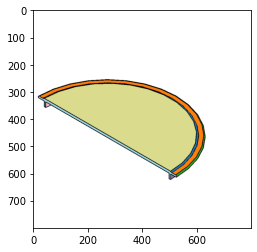

In [548]:
i = 2945
part = Part(data.open(parts_list[i]).read().decode('utf-8'))
pose, zoom = find_best_angle(part)
ground_truth = render_part(part, pose, zoom)
plt.imshow(ground_truth)

In [549]:
pdata = test_ds[i]
our_preds = classify_model(pdata).argmax(dim=1).numpy().astype(int)
gt = np.array(labels[i])
binary_labels = (gt == our_preds).astype(int)

In [562]:
labeled_gt = render_part(part, pose, zoom, face_labels=binary_labels, max_labels=2, cmap=orange_blue)

In [559]:
from matplotlib.colors import ListedColormap

In [561]:
#orange_blue = np.vectorize(lambda x: (255/255, 107/255, 0, 1.0) if x > 0.5 else (69/255, 130/255, 219/255, 1.0))

orange_blue = ListedColormap(np.array([(255/255, 107/255, 0, 1.0), (69/255, 130/255, 219/255, 1.0)]))

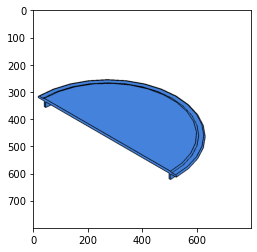

In [563]:
plt.imshow(labeled_gt)

In [599]:
selections =[1646, 1879, 2440, 1731]

classify_model = our_models[-1][1]

gts = []
renders = []
lgts = []
lrenders = []

for i in tqdm(selections):
    N = 100
    pdata = test_ds[i]
    preds = predict(codes[parts_list[i]]['x'], render_model, N)
    V, F, C = preds_to_mesh(preds, N)
    part = Part(data.open(parts_list[i]).read().decode('utf-8'))
    pose, zoom = find_best_angle(part)
    
    
    our_preds = classify_model(pdata).argmax(dim=1).numpy().astype(int)
    gt = np.array(labels[i])
    binary_labels = (gt == our_preds).astype(int)
        
    ground_truth = render_part(part, pose, zoom)
    rendering = render_mesh(V,F,C,pose,zoom)
    labeled_gt = render_part(part, pose, zoom, face_labels=binary_labels, max_labels=2, cmap=orange_blue)
    labeled_rendering = render_mesh(V,F,C,pose,zoom, face_labels=binary_labels, max_labels=2, cmap=orange_blue)
    gts.append(ground_truth)
    renders.append(rendering)
    lgts.append(labeled_gt)
    lrenders.append(labeled_rendering)


100%|█████████████████████████████████████████████████████████████████████| 4/4 [01:21<00:00, 20.28s/it]


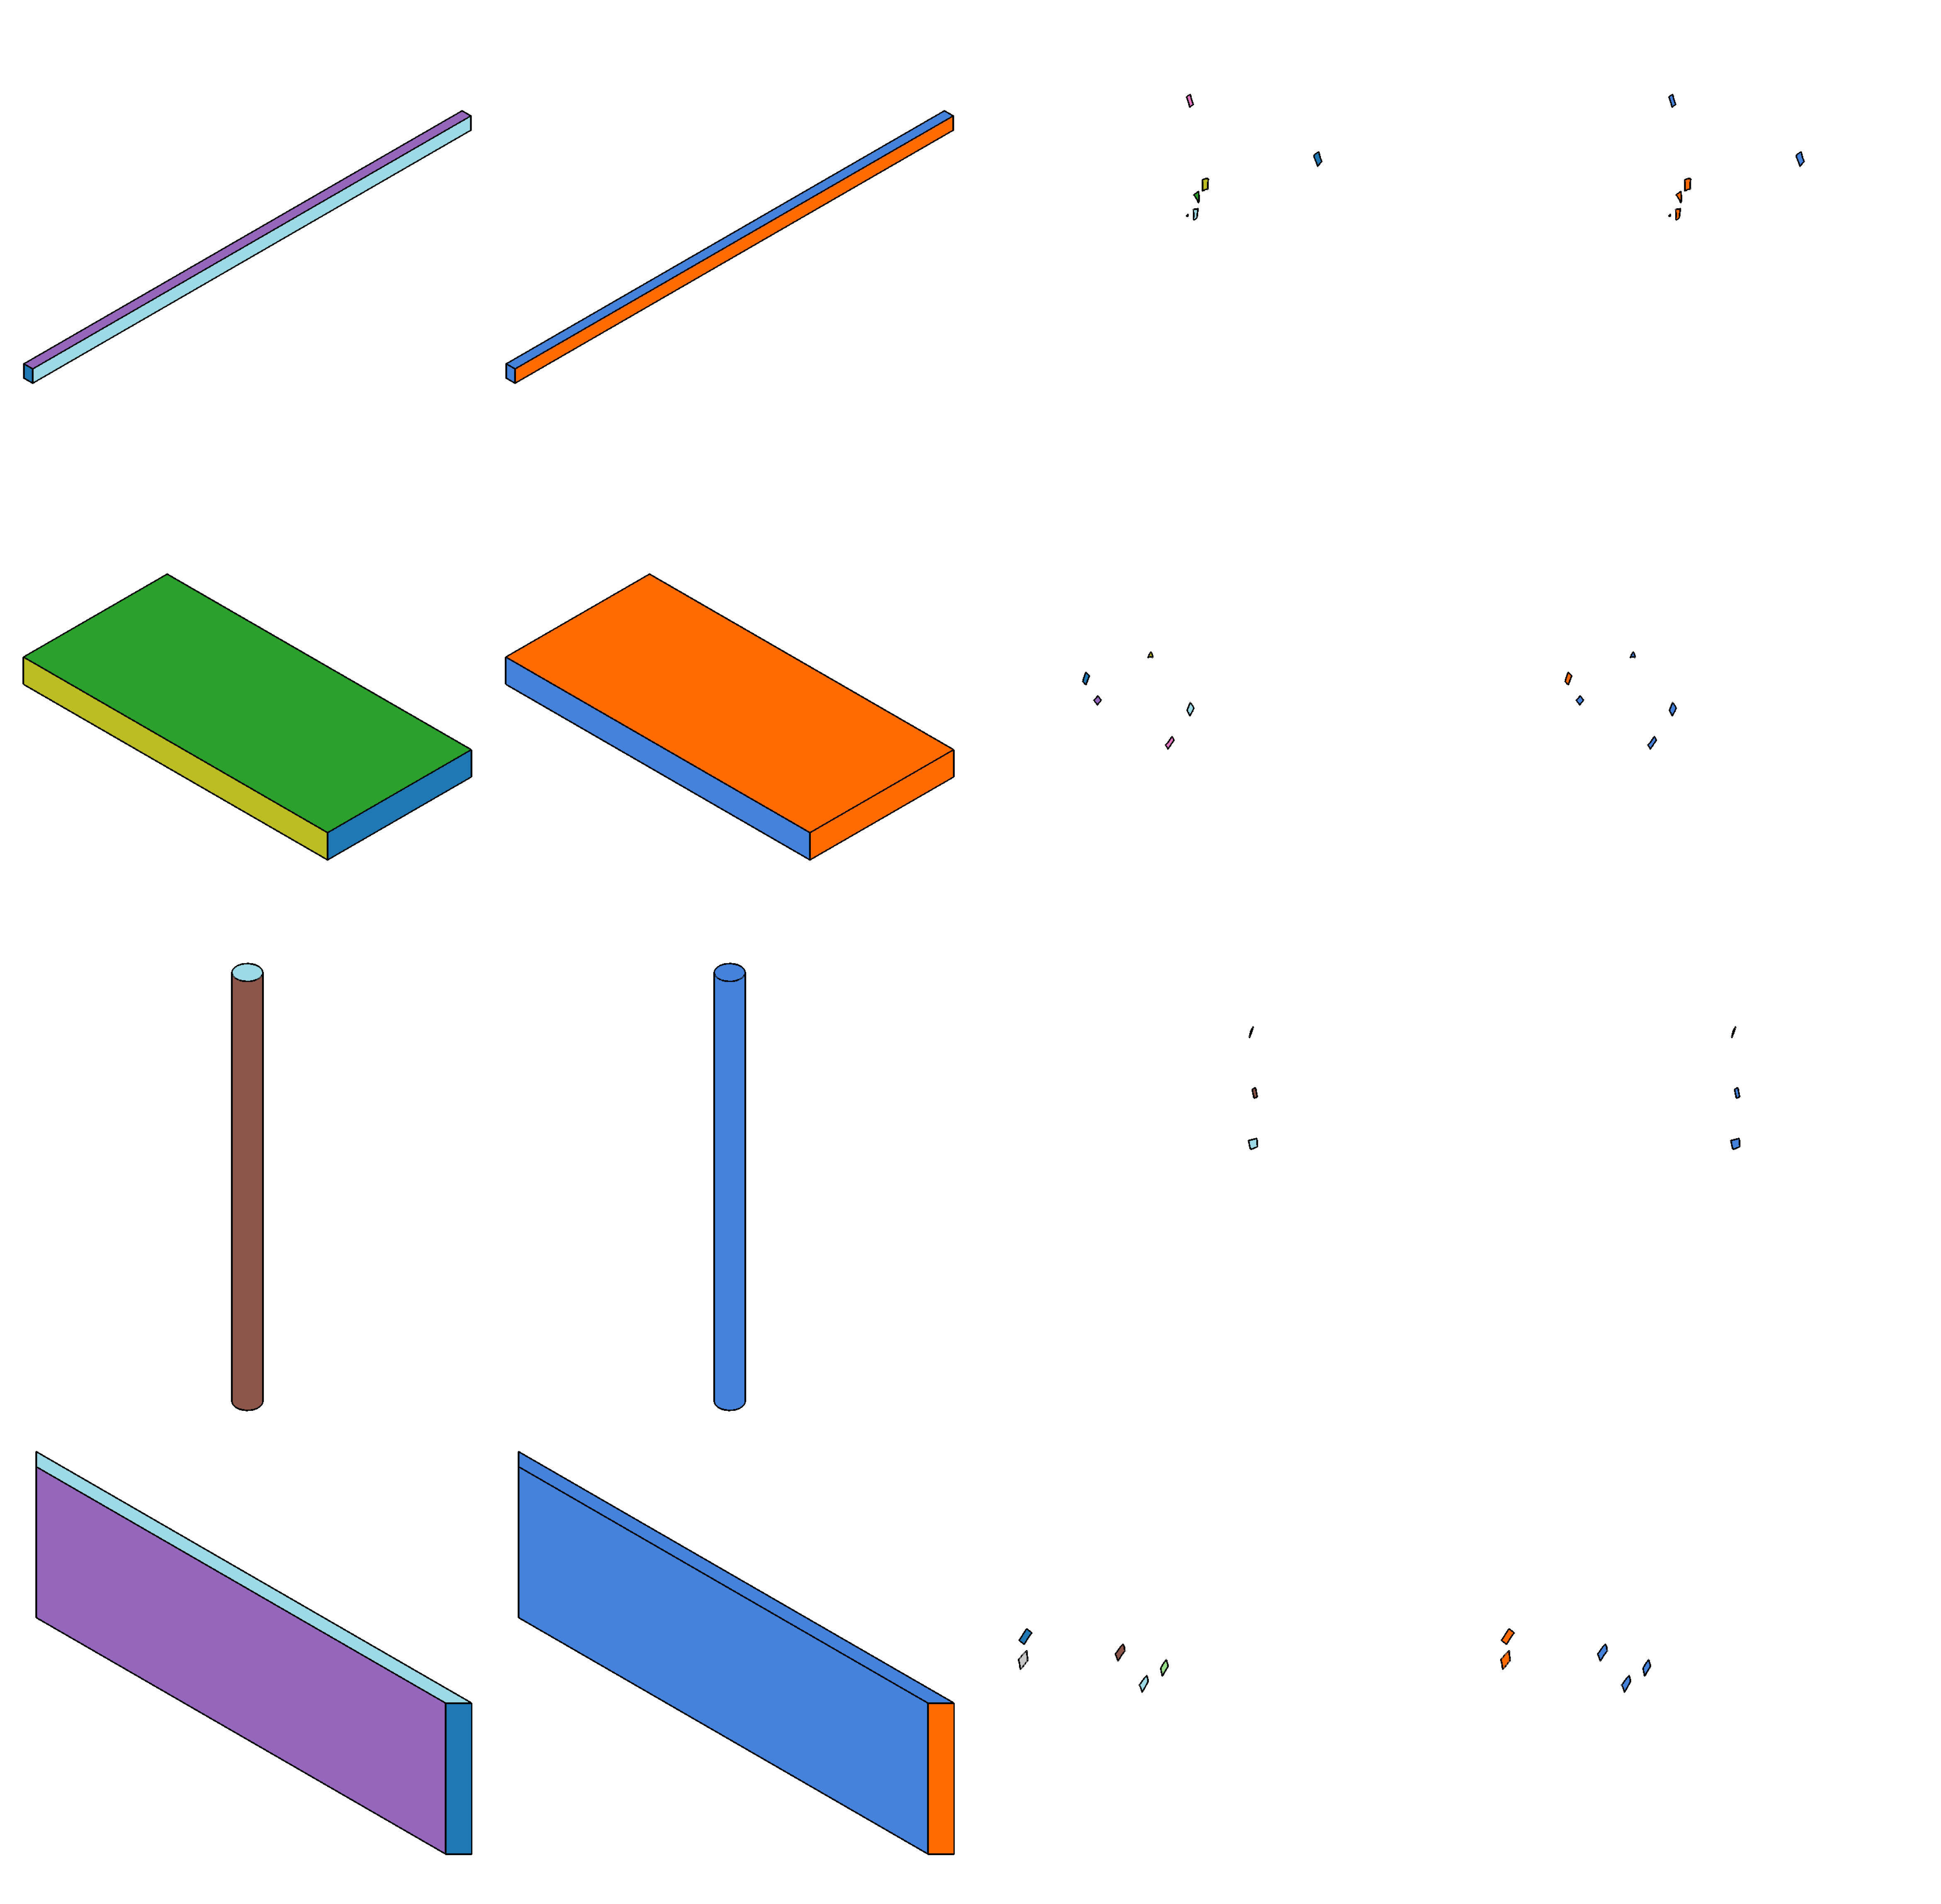

In [600]:
s=5
M = len(gts)
fig, axes = plt.subplots(M,4, figsize=(4*s,M*s),gridspec_kw={'wspace':0,'hspace':0},dpi=300)
for k in range(M):
    axes[k,0].imshow(gts[k])
    axes[k,1].imshow(lgts[k])
    axes[k,2].imshow(renders[k])
    axes[k,3].imshow(lrenders[k])
    for ax in axes[k]:
        ax.axis('off')